# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things:

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!

In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

In [2]:
%pip install -qU "langchain[google-genai]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

GOOGLE_API_KEY: ··········


## Messages as state

First, let's define some messages.

In [5]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Tharun"))

for m in messages:
  m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Tharun

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
llm.invoke(messages)

AIMessage(content='That\'s a great question! While whales (and dolphins and porpoises, which are all part of the **Cetacean** order) are iconic, there\'s a whole world of other fascinating ocean mammals out there.\n\nHere are the main groups you should definitely learn about:\n\n1.  **Pinnipeds (Seals, Sea Lions, and Walruses)**\n    *   **What they are:** These are "fin-footed" mammals that are semi-aquatic, meaning they spend a lot of time in the water hunting, but come ashore on land or ice to breed, rest, and molt.\n    *   **Key Differences:**\n        *   **True Seals (Phocidae):** Have no external ear flaps, short front flippers, and can\'t rotate their hind flippers forward, so they "scoot" or wiggle on their bellies on land. Examples: Harbor seals, harp seals, elephant seals, monk seals.\n        *   **Eared Seals (Otariidae):** Have small, visible ear flaps, longer front flippers, and can rotate their hind flippers forward to walk on all fours. Examples: Sea lions (like the C

We can run our chat model in a simple graph with ```MessagesState```


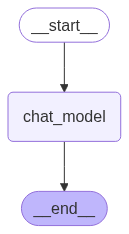

In [7]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
  return {"messages":llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model",chat_model_node)
builder.add_edge(START,"chat_model")
builder.add_edge("chat_model",END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
output = graph.invoke({"messages":messages})
for m in output["messages"]:
  m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Tharun

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's a great area of study! While whales (cetaceans) are certainly fascinating, there's a whole world of other incredible ocean mammals to explore. Here are some of the main groups you should definitely learn about:

1.  **Pinnipeds (Seals, Sea Lions, and Walruses):**
    *   **Characteristics:** These "fin-footed" mammals spend significant time in the water, but also come ashore to rest, breed, and molt. They have streamlined bodies, thick blubber for insulation, and flippers for swimming.
    *   **Seals (True Seals/Phocids):** They don't have external ear flaps and can't rotate their hind flippers forward, 

## Reducer

A practical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

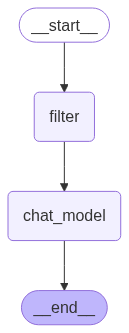

In [10]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
  # Delete all the th 2 most recent messages
  delete_messages = [RemoveMessage(id = m.id) for m in state["messages"][:-2]]
  return {"messages":delete_messages}

def chat_model_node(state: MessagesState):
  return {"messages":llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter",filter_messages)
builder.add_node("chat_model",chat_model_node)
builder.add_edge(START,"filter")
builder.add_edge("filter","chat_model")
builder.add_edge("chat_model",END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [11]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's a great question! While whales (and their relatives like dolphins and porpoises, which are all *cetaceans*) are certainly the most well-known, there's a whole world of other fascinating ocean mammals.

Here are the main groups you should definitely learn about:

1.  **Pinnipeds (Seals, Sea Lions, and Walruses)**
    *   **General:** These are "fin-footed" mammals, meaning their limbs have evolved into flippers. They spend most of their lives in the water, but come ashore to rest, breed, and give birth.
    *   **True Seals (Phocidae):**
        *   **Characteristics:** No visible external ear flaps. They m

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

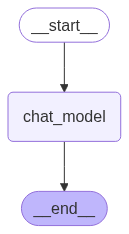

In [12]:
# Node
def chat_model_node(state: MessagesState):
  return {"messages":llm.invoke(state["messages"][-1:])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model",chat_model_node)
builder.add_edge(START,"chat_model")
builder.add_edge("chat_model",END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [13]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Tharun"))

In [14]:
for m in messages:
  m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's a great question! While whales (and their relatives like dolphins and porpoises, which are all *cetaceans*) are certainly the most well-known, there's a whole world of other fascinating ocean mammals.

Here are the main groups you should definitely learn about:

1.  **Pinnipeds (Seals, Sea Lions, and Walruses)**
    *   **General:** These are "fin-footed" mammals, meaning their limbs have evolved into flippers. They

In [15]:
# Invoke, using message filtering
output = graph.invoke({"messages":messages})
for m in output["messages"]:
  m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's a great question! While whales (and their relatives like dolphins and porpoises, which are all *cetaceans*) are certainly the most well-known, there's a whole world of other fascinating ocean mammals.

Here are the main groups you should definitely learn about:

1.  **Pinnipeds (Seals, Sea Lions, and Walruses)**
    *   **General:** These are "fin-footed" mammals, meaning their limbs have evolved into flippers. They

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens.

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

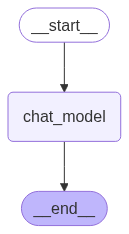

In [22]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
  messages = trim_messages(
      state["messages"],
      max_tokens=100,
      strategy="last",
      token_counter=ChatGoogleGenerativeAI(model="gemini-2.5-flash"),
      allow_partial=False,
  )
  return {"messages":[llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model",chat_model_node)
builder.add_edge(START,"chat_model")
builder.add_edge("chat_model",END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Tharun"))

In [24]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(model="gemini-2.5-flash"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Tharun')]

In [25]:
# Invoke, using message trimming in the chat_model_node
messages_out_trim = graph.invoke({'messages': messages})